In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from keras.datasets import fashion_mnist
from keras.datasets import mnist
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [25]:
def one_hot(y, n_labels):
    mat = np.zeros((len(y), n_labels))
    for i, val in enumerate(y):
        mat[i, val] = 1
    return mat.T

In [26]:
class MyNN(object):

    def __init__(self,network_size,network_fns,wb_init='he',learning_rate=1e-3,
                 optimizer = 'NADAM',keep_proba=1,regularize='l2',batch_size=32,
                 max_epoch=30,alpha=0,beta_1=0.9,beta_2=0.999,seed=None,verbose=0):
        
        self.network_size = network_size
        self.network_fns = network_fns
        self.wb_init = wb_init
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.keep_proba = keep_proba
        self.regularize = regularize
        self.seed = seed
        self.max_epoch = max_epoch
        self.verbose = verbose

    @staticmethod
    def weights_init(network_size,wb_init='he',seed=None):
        
        np.random.seed(seed)
        values = {}
        opt_values = {}
        L = len(network_size)            # number of layers in the network
        if  wb_init == 'he':
            for l in range(1, L):
                values['W' + str(l)] = np.random.normal(0,np.sqrt(2.0/network_size[l-1]),(network_size[l], network_size[l-1]))
                values['b' + str(l)] = np.random.normal(0,np.sqrt(2.0/network_size[l-1]),(network_size[l], 1))  
               
        elif wb_init == 'xavier_uniform':
            for l in range(1, L):
                values['W' + str(l)] = np.random.uniform(-(np.sqrt(6.0/(network_size[l]+network_size[l-1]))),
                                                        (np.sqrt(6.0/(network_size[l]+network_size[l-1]))),
                                                        (network_size[l], network_size[l-1]))
                values['b' + str(l)] = np.random.uniform(-(np.sqrt(6.0/(network_size[l]+network_size[l-1]))),
                                                        (np.sqrt(6.0/(network_size[l]+network_size[l-1]))),
                                                        (network_size[l], 1))

        return values
    
    @staticmethod
    def ReLU(X,alpha=0,derivative=False):
        X = np.array(X,dtype=np.float64)
        if derivative == False:
            return np.where(X<0,alpha*X,X)
        elif derivative == True:
            X_relu = np.ones_like(X,dtype=np.float64)
            X_relu[X < 0] = alpha
            return X_relu

    @staticmethod
    def sigmoid(X,derivative=False):
        if derivative == False:
            out = 1 / (1 + np.exp(-np.array(X)))
        elif derivative == True:
            s = 1 / (1 + np.exp(-np.array(X)))
            out = s*(1-s)
        return out
    
    @staticmethod
    def Tanh(X,derivative=False):
        X = np.array(X)
        if derivative == False:
            return np.tanh(X)
        if derivative == True:
            return 1 - (np.tanh(X))**2
            
    @staticmethod
    def softmax(X):
        return np.exp(X) / np.sum(np.exp(X),axis=0)
    
    @staticmethod
    def forward_prop(X, network_fns,values,keep_prob=1,seed=None):
    
        if seed != None:
            np.random.seed(seed)
        caches = []
        A = X
        L = len(network_fns)
        for l,act_fn in enumerate(network_fns,start=1):
            A_prev = A 
        
            Z = np.dot(values['W' + str(l)],A_prev)+values['b' + str(l)]
            
            if type(act_fn) is tuple:
                
                if  act_fn[0] == "relu":
                    A = MyNN.ReLU(Z,act_fn[1])
            else:
                if act_fn == "sigmoid":
                    A = MyNN.sigmoid(Z)
                elif act_fn == "tanh":
                    A = MyNN.Tanh(Z)
                elif act_fn == "softmax":
                    A = MyNN.softmax(Z)
                elif  act_fn == "relu":
                    A = MyNN.ReLU(Z)
            
            if keep_prob != 1 and l != L and l != 1:
                D = np.random.rand(A.shape[0],A.shape[1])
                D = (D<keep_prob)
                A = np.multiply(A,D)
                A = A / keep_prob
                cache = ((A_prev, values['W' + str(l)],values['b' + str(l)],D), Z)
                caches.append(cache)
            else:
                cache = ((A_prev, values['W' + str(l)],values['b' + str(l)]), Z)
                #print(A.shape)
                caches.append(cache)      
        return A, caches

    @staticmethod
    def compute_loss(A, Y, values, alpha=0,regularize=None):

        m = Y.shape[1]
    
        loss = np.squeeze(-np.sum(np.multiply(np.log(A),Y))/m)
        #loss = np.squeeze(np.sum((Y - A)**2)/m)
    
        L = len(values)//2
    
        if regularize == 'l2' and alpha != 0:
            sum_weights = 0
            for l in range(1, L):
                sum_weights = sum_weights + np.sum(np.square(values['W' + str(l)]))
            loss = loss + sum_weights * (alpha/(2*m))
        elif regularize == 'l1' and alpha != 0:
            sum_weights = 0
            for l in range(1, L):
                sum_weights = sum_weights + np.sum(np.abs(values['W' + str(l)]))
            loss = loss + sum_weights * (alpha/(2*m))
        return loss

    @staticmethod
    def back_prop(AL, Y, caches, network_fns, keep_prob=1, regularize=None,alpha=0):

        grads = {}
        L = len(caches)
    
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
    
        # Initializing the backprop
        dZL = AL - Y
    
        cache = caches[L-1]
        linear_cache, activation_cache = cache
        AL, W, b = linear_cache
        grads["dW" + str(L)] = np.dot(dZL,AL.T)/m
        grads["db" + str(L)] = np.sum(dZL,axis=1,keepdims=True)/m
        grads["dA" + str(L-1)] = np.dot(W.T,dZL)
    
            
        v_dropout = 0
        for l in reversed(range(L-1)):
            cache = caches[l]
            act_fn = network_fns[l]
        
            linear_cache, Z = cache
            try:
                A_prev, W, b = linear_cache
            except:
                A_prev, W, b, D = linear_cache
                v_dropout = 1
            
            m = A_prev.shape[1]
        
            if keep_prob != 1 and v_dropout == 1:
                dA_prev = np.multiply(grads["dA" + str(l + 1)],D)
                dA_prev = dA_prev/keep_prob
                v_dropout = 0
            else:
                dA_prev = grads["dA" + str(l + 1)]
                v_dropout = 0
            
            
            if type(act_fn) is tuple:
                
                if  act_fn[0] == "relu":
                    dZ = np.multiply(dA_prev,MyNN.ReLU(Z,act_fn[1],derivative=True))

            else:
                if act_fn == "sigmoid":
                    dZ = np.multiply(dA_prev,MyNN.sigmoid(Z,derivative=True))
                elif act_fn == "relu":
                    dZ = np.multiply(dA_prev,MyNN.ReLU(Z,derivative=True))
                elif act_fn == "tanh":
                    dZ = np.multiply(dA_prev,MyNN.Tanh(Z,derivative=True))
            
            grads["dA" + str(l)] = np.dot(W.T,dZ)
        
            if regularize == 'l2':
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)  + ((alpha * W)/m)
            elif regularize == 'l1':
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)  + ((alpha * np.sign(W+10**-8))/m)
            else:
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)
            
            grads["db" + str(l + 1)] = np.sum(dZ,axis=1,keepdims=True)/m   
        return grads
    
    @staticmethod
    def update_values(values, grads,learning_rate,iter_no,method = 'SGD',opt_values=None,beta_1=0.9,beta_2=0.999):
    
        L = len(values) // 2 
        if method == 'SGD':
            for l in range(L):
                values["W" + str(l+1)] = values["W" + str(l+1)] - learning_rate*grads["dW" + str(l + 1)]
                values["b" + str(l+1)] = values["b" + str(l+1)] - learning_rate*grads["db" + str(l + 1)]
            opt_values = None
        elif method == 'SGDM':
            for l in range(L):
                opt_values['vdb'+str(l+1)] = beta_1*opt_values['vdb'+str(l+1)] + (1-beta_1)*grads["db" + str(l + 1)]
                opt_values['vdw'+str(l+1)] = beta_1*opt_values['vdw'+str(l+1)] + (1-beta_1)*grads["dW" + str(l + 1)]
                values["W" + str(l+1)] = values["W" + str(l+1)] - learning_rate*opt_values['vdw'+str(l+1)]
                values["b" + str(l+1)] = values["b" + str(l+1)] - learning_rate*opt_values['vdb'+str(l+1)]
        elif method == 'RMSP':
            for l in range(L):
                opt_values['sdb'+str(l+1)] = beta_2*opt_values['sdb'+str(l+1)] + \
                                                     (1-beta_2)*np.square(grads["db" + str(l + 1)])
                opt_values['sdw'+str(l+1)] = beta_2*opt_values['sdw'+str(l+1)] + \
                                                           (1-beta_2)*np.square(grads["dW" + str(l + 1)])
                values["W" + str(l+1)] = values["W" + str(l+1)] - \
                                       learning_rate*(grads["dW" + str(l + 1)]/(np.sqrt(opt_values['sdw'+str(l+1)])+10**-8))
                values["b" + str(l+1)] = values["b" + str(l+1)] - \
                                       learning_rate*(grads["db" + str(l + 1)]/(np.sqrt(opt_values['sdb'+str(l+1)])+10**-8))
        elif method == 'ADAM':
            for l in range(L):
                opt_values['vdb'+str(l+1)] = beta_1*opt_values['vdb'+str(l+1)] + (1-beta_1)*grads["db" + str(l + 1)]
                opt_values['vdw'+str(l+1)] = beta_1*opt_values['vdw'+str(l+1)] + (1-beta_1)*grads["dW" + str(l + 1)]
                opt_values['sdb'+str(l+1)] = beta_2*opt_values['sdb'+str(l+1)] + \
                                                                  (1-beta_2)*np.square(grads["db" + str(l + 1)])
                opt_values['sdw'+str(l+1)] = beta_2*opt_values['sdw'+str(l+1)] + \
                                                                   (1-beta_2)*np.square(grads["dW" + str(l + 1)])
            
                learning_rate = learning_rate * np.sqrt((1-beta_2**iter_no)/((1-beta_1**iter_no)+10**-8))
                values["W" + str(l+1)] = values["W" + str(l+1)] - \
                                       learning_rate*(opt_values['vdw'+str(l+1)]/\
                                                      (np.sqrt(opt_values['sdw'+str(l+1)])+10**-8))
                values["b" + str(l+1)] = values["b" + str(l+1)] - \
                                       learning_rate*(opt_values['vdb'+str(l+1)]/\
                                                      (np.sqrt(opt_values['sdb'+str(l+1)])+10**-8))
        
        elif method == 'NADAM':
            for l in range(L):
                opt_values['vdb'+str(l+1)] = beta_1*opt_values['vdb'+str(l+1)] + (1-beta_1)*grads["db" + str(l + 1)]
                opt_values['vdw'+str(l+1)] = beta_1*opt_values['vdw'+str(l+1)] + (1-beta_1)*grads["dW" + str(l + 1)]
                opt_values['sdb'+str(l+1)] = beta_2*opt_values['sdb'+str(l+1)] + \
                                                                  (1-beta_2)*np.square(grads["db" + str(l + 1)])
                opt_values['sdw'+str(l+1)] = beta_2*opt_values['sdw'+str(l+1)] + \
                                                                   (1-beta_2)*np.square(grads["dW" + str(l + 1)])
            
                
                learning_rate = learning_rate * np.sqrt((1-beta_2**iter_no)/((1-beta_1**iter_no)+10**-8))
                values["W" + str(l+1)] = values["W" + str(l+1)] - \
                                       learning_rate*((beta_1*opt_values['vdw'+str(l+1)])/\
                                                      (np.sqrt(opt_values['sdw'+str(l+1)])+10**-8))
                values["b" + str(l+1)] = values["b" + str(l+1)] - \
                                       learning_rate*((beta_1*opt_values['vdb'+str(l+1)]+ (1-beta_1)*grads["db" + str(l + 1)])/\
                                                      (np.sqrt(opt_values['sdb'+str(l+1)])+10**-8))
        
        return values,opt_values
    
    def fit(self,X,y,x_valid,y_valid):

        x_train = X
        y_train = y
        X_valid = X
        Y_valid = y
        y = one_hot(y, 10)
        np.random.seed(self.seed)
        self.grads = {}
        self.losss = []
        M = X.shape[1]
        opt_values = {}
        
        if self.verbose == 1:
            print('Initilizing Weights...')
        self.values = self.weights_init(self.network_size,self.wb_init,self.seed)
        self.iter_no = 0
        idx = np.arange(0,M)
        
        if self.optimizer != 'SGD':
            for l in range(1, len(self.network_size)):
                opt_values['vdw' + str(l)] = np.zeros((self.network_size[l], self.network_size[l-1]))
                opt_values['vdb' + str(l)] = np.zeros((self.network_size[l], 1))
                opt_values['sdw' + str(l)] = np.zeros((self.network_size[l], self.network_size[l-1]))
                opt_values['sdb' + str(l)] = np.zeros((self.network_size[l], 1)) 
        
        if self.verbose == 1:
            print('Starting Training...')
            
        for epoch_no in range(1,self.max_epoch+1):
            acc_epoch = []
            np.random.shuffle(idx)
            X = X[:,idx]
            y = y[:,idx]
            for i in range(0,M, self.batch_size):
                self.iter_no = self.iter_no + 1
                X_batch = X[:,i:i + self.batch_size]
                y_batch = y[:,i:i + self.batch_size]
                # Forward prop:
                AL, cache = self.forward_prop(X_batch,self.network_fns,self.values,self.keep_proba,self.seed)
                #loss
                loss = self.compute_loss(AL, y_batch, self.values,self.alpha,self.regularize)
                self.losss.append(loss)
                
                
                #back prop
                grads = self.back_prop(AL, y_batch, cache,self.network_fns,self.keep_proba,self.regularize,self.alpha)
                
                #update params
                self.values,opt_values = self.update_values(self.values,grads,self.learning_rate,
                                                                        self.iter_no-1,self.optimizer,
                                                                        opt_values,self.beta_1,self.beta_2)
                                
                if self.verbose == 1:
                    if self.iter_no % 1000 == 0:
                        
                        print("loss after iteration {}: {}".format(self.iter_no, loss))
                        #wandb.log({'Training Error' : loss}
                
                #wandb.log({'Training Loss' : loss})
                

            y_pred_train = self.predict(x_train)
            y_pred_valid = self.predict(x_valid)

            train_acc = accuracy_score(y_train, y_pred_train)
            valid_acc = accuracy_score(y_valid, y_pred_valid)

            if self.verbose == 1:
              print('Train Accuracy: %.2f%%' % (train_acc * 100))
              print('Validation Accuracy: %.2f%%' % (valid_acc * 100))
            
            #wandb.log({'Training accuracy per epoch' : train_acc})
            #wandb.log({'Validation accuracy per epoch' : valid_acc})
            acc_epoch.append(valid_acc)

        acc_best = max(acc_epoch)
        if self.verbose == 1:
          print('Best Validation Accuracy: %.2f%%' % (acc_best * 100))
          
        #wandb.log({'accuracy' : valid_acc})
        return self
    def predict(self,X,proba=False):
        
        out, _ = self.forward_prop(X,self.network_fns,self.values,self.keep_proba,self.seed)
        if proba == True:
            return out.T
        else:
            return np.argmax(out, axis=0)

11493376/11490434 [==============================] - 2s 0us/step


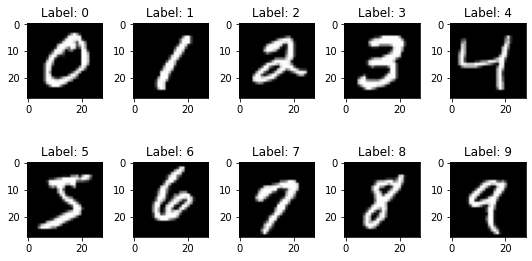

In [28]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


class_num = 10
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(class_num):
  ax = axes[i//num_col, i%num_col]
  a = np.argmax(y_train == i)
  ax.imshow(x_train[a], cmap='gray')
  ax.set_title('Label: {}'.format(y_train[a]))
plt.tight_layout()

In [29]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=0, stratify=y_train)

x_train = x_train.reshape((len(x_train), 28*28))
x_train = x_train.astype('float32') / 255

x_valid = x_valid.reshape((len(x_valid), 28*28))
x_valid = x_valid.astype('float32') / 255

# Preprocessing test data
x_test = x_test.reshape((len(x_test), 28 * 28))
x_test = x_test.astype('float32') / 225

X = x_train.T
x_valid = x_valid.T
Y = y_train

In [30]:
model = MyNN(network_size=[X.shape[0], 128, 128, 128, 128, 10],network_fns=['tanh','tanh','tanh','tanh','softmax'],batch_size = 64,
             optimizer='NADAM',regularize= 'l2',alpha = 0, wb_init = 'xavier_uniform', learning_rate = 1e-3,
             max_epoch=30,verbose=1,seed=25)

In [34]:
model = MyNN(network_size=[X.shape[0], 128, 128, 128, 128, 10],network_fns=['tanh','tanh','tanh','tanh','softmax'],batch_size = 32,
             optimizer='ADAM',regularize= 'l2',alpha = 0.0005, wb_init = 'xavier_uniform', learning_rate = 1e-3,
             max_epoch=30,verbose=1,seed=25)

In [40]:
model = MyNN(network_size=[X.shape[0], 128, 128, 128, 128,128, 10],
             network_fns=[('relu',0),('relu',0),('relu',0),('relu',0),('relu',0),'softmax'],
             batch_size = 32, optimizer='ADAM',regularize= 'l2',alpha = 0.0005, wb_init = 'he', learning_rate = 1e-3,
             max_epoch=30,verbose=1,seed=25)

In [41]:
model.fit(X,Y,x_valid,y_valid)

Initilizing Weights...
Starting Training...
loss after iteration 1000: 0.03823857544133261
Train Accuracy: 95.99%
Validation Accuracy: 95.28%
loss after iteration 2000: 0.3213349443277617
loss after iteration 3000: 0.14295606387578078
Train Accuracy: 97.35%
Validation Accuracy: 96.22%
loss after iteration 4000: 0.19975306735449969
loss after iteration 5000: 0.041964776583609135
Train Accuracy: 97.70%
Validation Accuracy: 96.78%
loss after iteration 6000: 0.11884446955496444
Train Accuracy: 98.32%
Validation Accuracy: 97.10%
loss after iteration 7000: 0.016628865589374382
loss after iteration 8000: 0.12158191415716427
Train Accuracy: 98.38%
Validation Accuracy: 97.02%
loss after iteration 9000: 0.09027444215558343
loss after iteration 10000: 0.07832742478071415
Train Accuracy: 98.85%
Validation Accuracy: 97.52%
loss after iteration 11000: 0.03842026337510637
Train Accuracy: 98.79%
Validation Accuracy: 97.22%
loss after iteration 12000: 0.0922226891465911
loss after iteration 13000: 0.01

In [42]:
X_test = x_test.T
y_pred= model.predict(X_test)

#print(y_pred)
print('Test Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred)*100))

Test Accuracy: 97.99%


<AxesSubplot:>

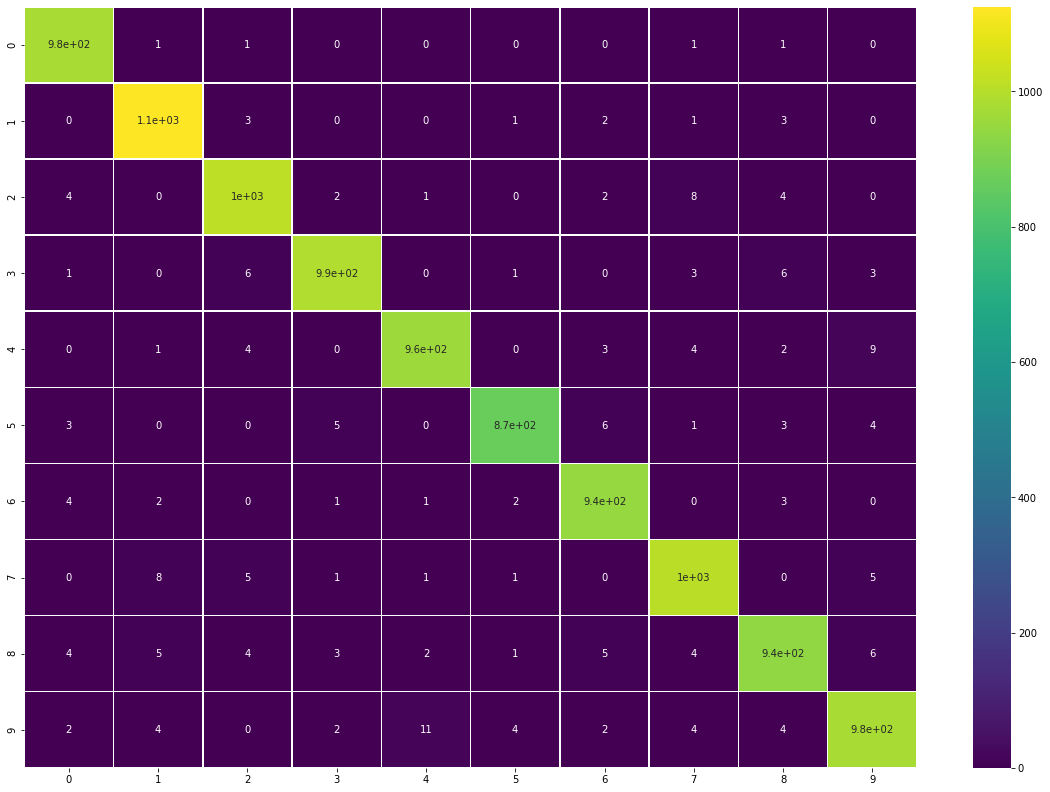

In [43]:
cf_matrix = confusion_matrix(y_test, y_pred)

import seaborn as sns
fig, ax = plt.subplots(figsize=(20,14))    
sns.heatmap(cf_matrix, cmap='viridis', annot=True, linewidths=.5, ax=ax)

In [50]:
def model_test(X,Y,x_test,y_test,n_hidden,n_class,hidden_size,activation):
      
  layers = []
  for i in range(n_hidden+2):
    if i == 0:
        layers.append(X.shape[0])
    elif i == n_hidden+1:
        layers.append(n_class)
    else:
        layers.append(hidden_size)
    i = i+1

  #print(layers)

  o_act = 'softmax'
  if activation == 'relu':
    actvn_fn = ('relu',0)
  else:
    actvn_fn = activation

  act = []
  for i in range(n_hidden+1):
    if i == n_hidden:
      act.append(o_act)
    else:
      act.append(actvn_fn)
    i = i+1

    
  model = MyNN(network_size=layers,network_fns=act,batch_size = 64,
             optimizer='NADAM',regularize= 'l2',alpha = 0, wb_init = 'xavier_uniform', learning_rate = 1e-3,
             max_epoch=5,verbose=1,seed=25)
    
  model.fit(X,Y,x_valid,y_valid)
    
  X_test = x_test.T
  y_pred= model.predict(X_test)

  #print(y_pred)
  print('Test Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred)*100))
    
  cf_matrix = confusion_matrix(y_test, y_pred)

  import seaborn as sns
  fig, ax = plt.subplots(figsize=(20,14))    
  sns.heatmap(cf_matrix, cmap='viridis', annot=True, linewidths=.5, ax=ax)

Initilizing Weights...
Starting Training...
Train Accuracy: 94.82%
Validation Accuracy: 94.48%
loss after iteration 1000: 0.15605340355404002
Train Accuracy: 96.87%
Validation Accuracy: 95.78%
loss after iteration 2000: 0.2755477811425593
Train Accuracy: 97.11%
Validation Accuracy: 96.15%
loss after iteration 3000: 0.05079694305037675
Train Accuracy: 98.57%
Validation Accuracy: 97.05%
loss after iteration 4000: 0.04360717274045771
Train Accuracy: 97.70%
Validation Accuracy: 96.08%
Best Validation Accuracy: 96.08%
Test Accuracy: 96.40%


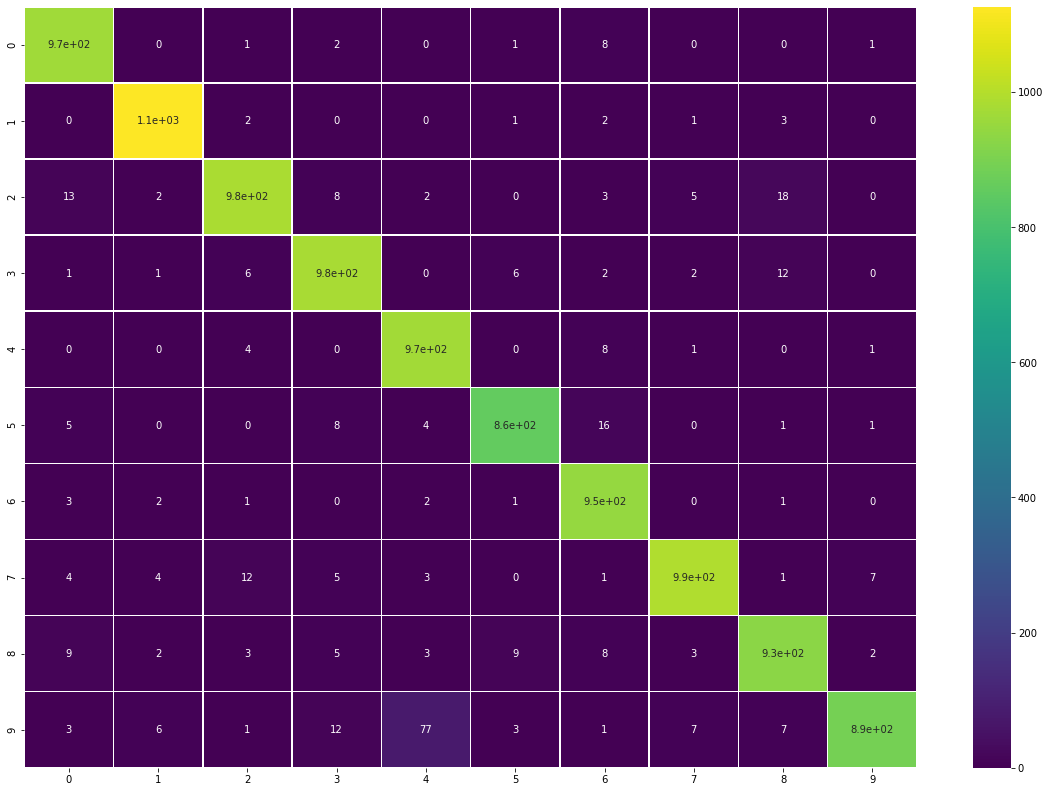

In [51]:
n_hidden = 4
n_class = 10
hidden_size = 128
activation = 'tanh'
#activation = 'relu'
model_test(X,Y,x_test,y_test,n_hidden,n_class,hidden_size,activation)

In [46]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='micro')

0.9799